In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.insert(0,'/content/drive/My Drive/python_modules')
sys.path.insert(1,'/content/drive/My Drive/data_files')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from scipy.stats import norm

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Utill-Class

In [5]:
from EDA import EDA
from GradientDescent import GradientDescent

# Read Data

In [6]:
data = pd.read_csv("/content/drive/MyDrive/data_files/weatherHistory.csv", parse_dates=['Formatted Date'])
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00+02:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00+02:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00+02:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00+02:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00+02:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [8]:
data['Summary'].value_counts() / 96000

Partly Cloudy                          0.330552
Mostly Cloudy                          0.292646
Overcast                               0.172885
Clear                                  0.113437
Foggy                                  0.074458
Breezy and Overcast                    0.005500
Breezy and Mostly Cloudy               0.005375
Breezy and Partly Cloudy               0.004021
Dry and Partly Cloudy                  0.000896
Windy and Partly Cloudy                0.000698
Light Rain                             0.000656
Breezy                                 0.000562
Windy and Overcast                     0.000469
Humid and Mostly Cloudy                0.000417
Drizzle                                0.000406
Breezy and Foggy                       0.000365
Windy and Mostly Cloudy                0.000365
Dry                                    0.000354
Humid and Partly Cloudy                0.000177
Dry and Mostly Cloudy                  0.000146
Rain                                   0

In [9]:
data['Daily Summary'].value_counts()

Mostly cloudy throughout the day.                                                                       20085
Partly cloudy throughout the day.                                                                        9981
Partly cloudy until night.                                                                               6169
Partly cloudy starting in the morning.                                                                   5184
Foggy in the morning.                                                                                    4201
                                                                                                        ...  
Breezy starting overnight continuing until morning and foggy overnight.                                    24
Mostly cloudy throughout the day and breezy starting overnight continuing until afternoon.                 24
Partly cloudy starting in the morning and breezy starting in the afternoon continuing until evening.       24
Rain until

In [10]:
data['Precip Type'].value_counts()

rain    85224
snow    10712
Name: Precip Type, dtype: int64

In [11]:
data.isna().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [12]:
data.dropna(inplace=True)

In [13]:
data.isna().sum()

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

In [14]:
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)

In [15]:
data.set_index('Formatted Date', inplace=True)

In [16]:
data.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
Formatted Date,,,,,,,,,,,
2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


> ### Resample data to be daily based

In [17]:
data = data.resample('D').mean()

In [18]:
data.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Formatted Date,,,,,,,,
2005-12-31 00:00:00+00:00,0.577778,-4.050000,0.890000,17.114300,140.000000,9.982000,0.0,1016.660000
2006-01-01 00:00:00+00:00,4.075000,-0.174537,0.817083,21.229192,142.750000,11.348487,0.0,1011.985000
2006-01-02 00:00:00+00:00,5.263194,1.808796,0.847083,17.824713,164.583333,8.492079,0.0,1010.384167
2006-01-03 00:00:00+00:00,2.340509,0.445370,0.897083,7.726658,252.541667,9.223958,0.0,1021.170833
2006-01-04 00:00:00+00:00,2.251852,-0.663194,0.906667,12.152817,35.000000,8.352546,0.0,981.770833


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4019 entries, 2005-12-31 00:00:00+00:00 to 2016-12-31 00:00:00+00:00
Freq: D
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (C)           4009 non-null   float64
 1   Apparent Temperature (C)  4009 non-null   float64
 2   Humidity                  4009 non-null   float64
 3   Wind Speed (km/h)         4009 non-null   float64
 4   Wind Bearing (degrees)    4009 non-null   float64
 5   Visibility (km)           4009 non-null   float64
 6   Loud Cover                4009 non-null   float64
 7   Pressure (millibars)      4009 non-null   float64
dtypes: float64(8)
memory usage: 282.6 KB


In [20]:
data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.000000,4009.0,4009.000000
mean,11.935733,10.857642,0.734929,10.809954,187.470385,10.360380,0.0,1003.147247
std,8.797203,9.950519,0.135152,5.005772,67.283457,3.194362,0.0,71.390660
min,-15.958796,-18.825463,0.297500,1.110900,7.708333,0.000000,0.0,336.542500
25%,5.004630,2.744444,0.631667,7.226217,141.083333,8.891225,0.0,1010.806667
50%,12.220370,11.891204,0.744167,9.923637,183.583333,11.318971,0.0,1015.967917
75%,19.196296,19.196296,0.843333,13.355621,237.541667,12.077013,0.0,1020.520417
max,30.814352,30.034028,0.995000,37.929588,336.416667,15.924912,0.0,1043.532083


In [21]:
data['Loud Cover'].value_counts()

0.0    4009
Name: Loud Cover, dtype: int64

In [22]:
data.drop(columns='Loud Cover', inplace=True)

# EDA

## 1- Split data into train, validation and test

In [23]:
train_val_data, test_data = train_test_split(data, test_size=.2, random_state=0)

In [24]:
train_data, val_data = train_test_split(train_val_data, test_size=.2, random_state=0)

## 2- Load data in the class

In [25]:
WeatherData = EDA(train_data=train_data, target='Apparent Temperature (C)', val_data=val_data, test_data=test_data)

## Visualize data

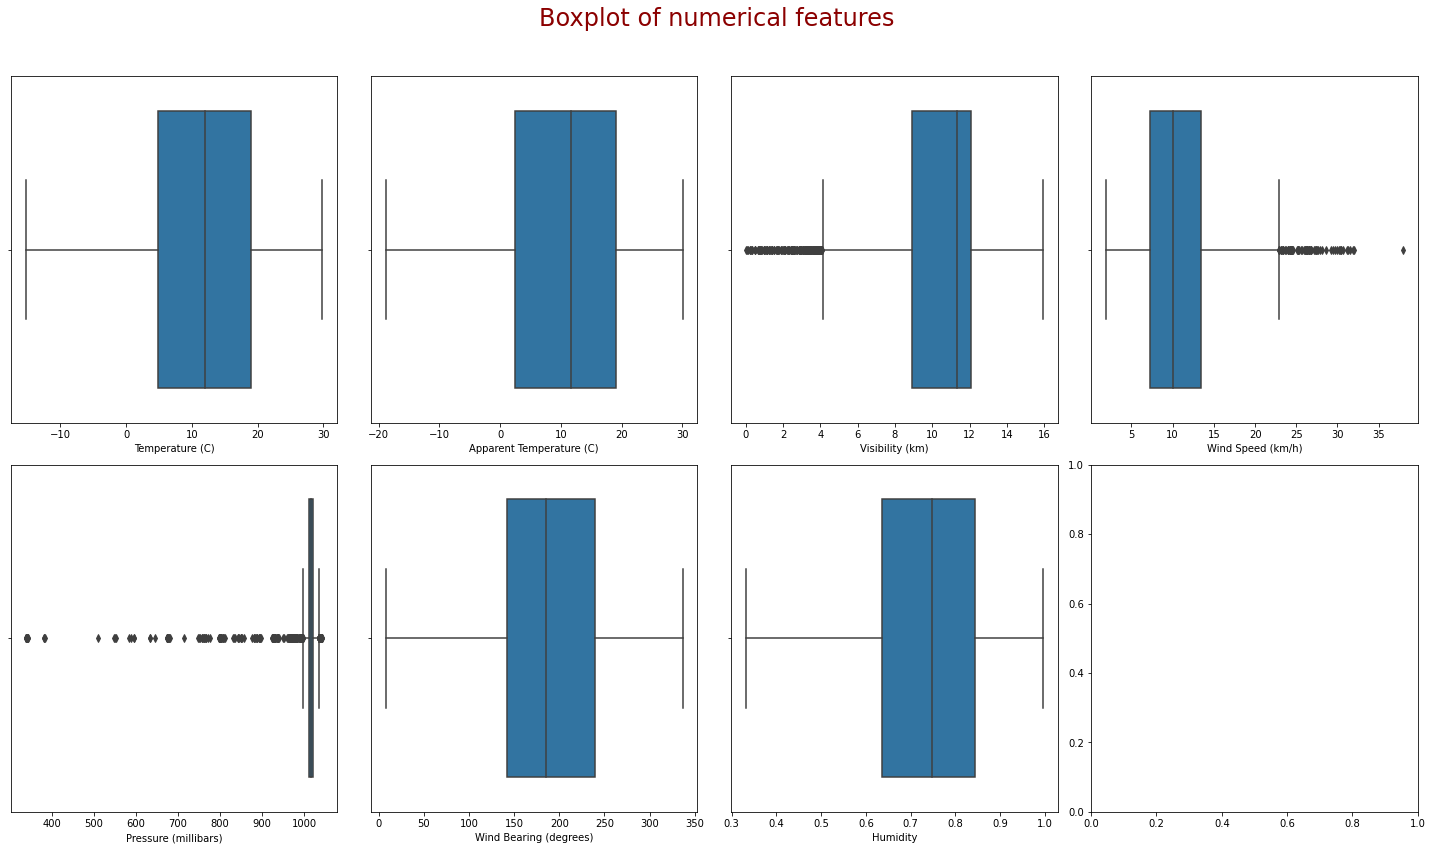

In [26]:
WeatherData.visualize('boxplot')

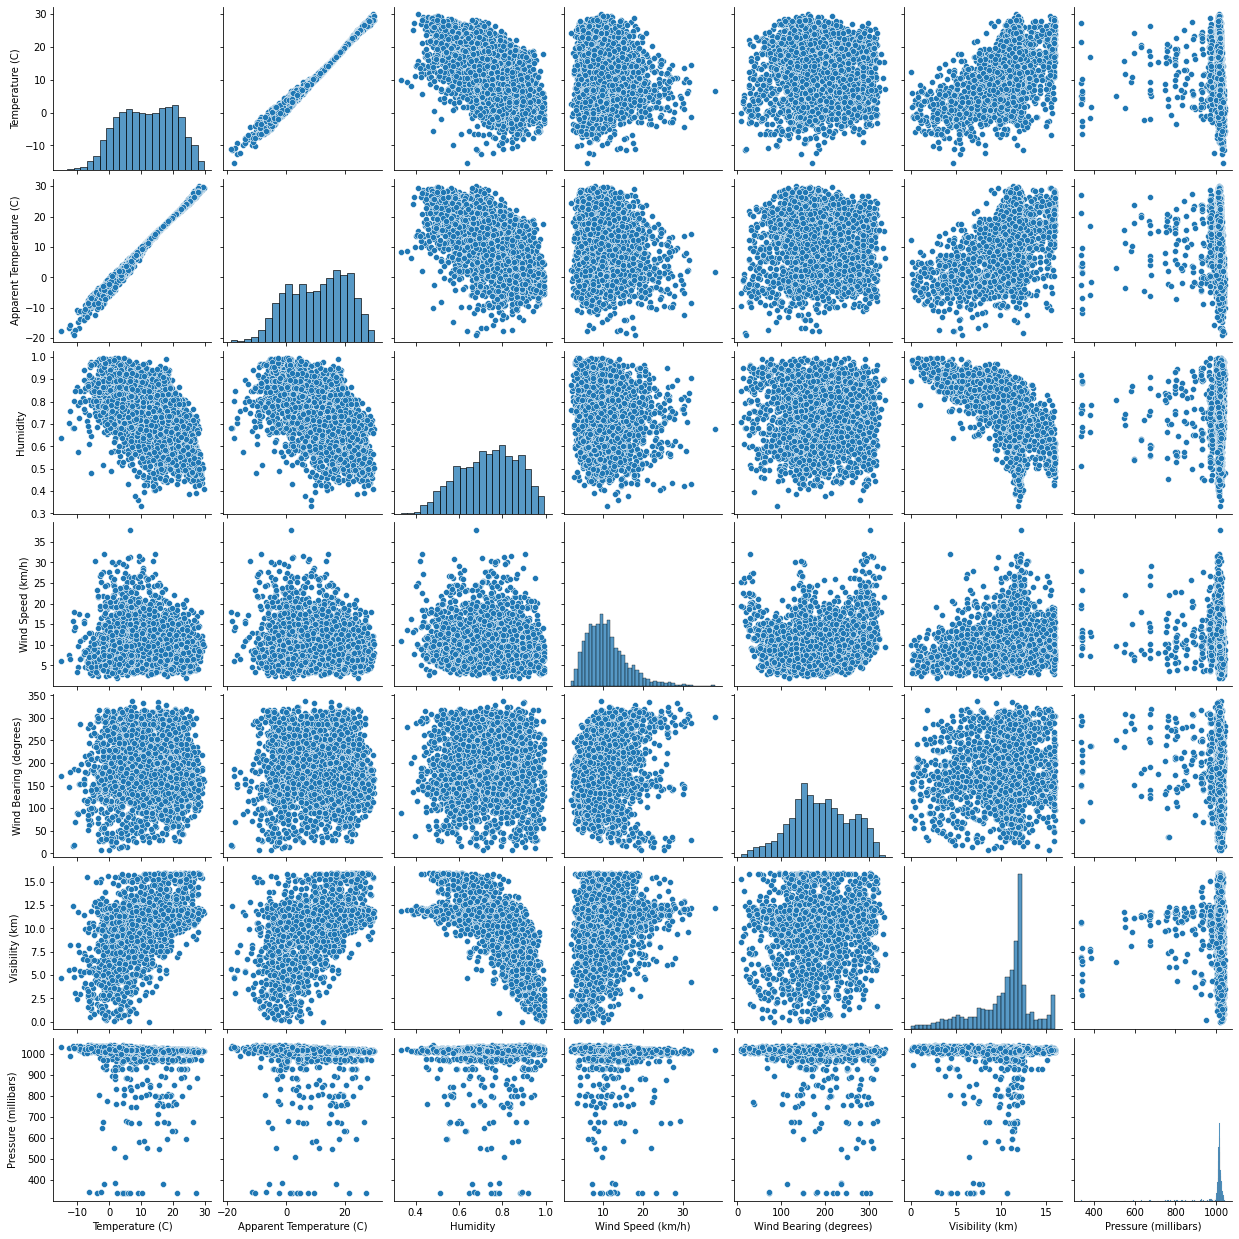

In [27]:
sns.pairplot(WeatherData.train_data);

From the pair plots it seem that Temperature and Apparent Temperature is the only high correlated feature

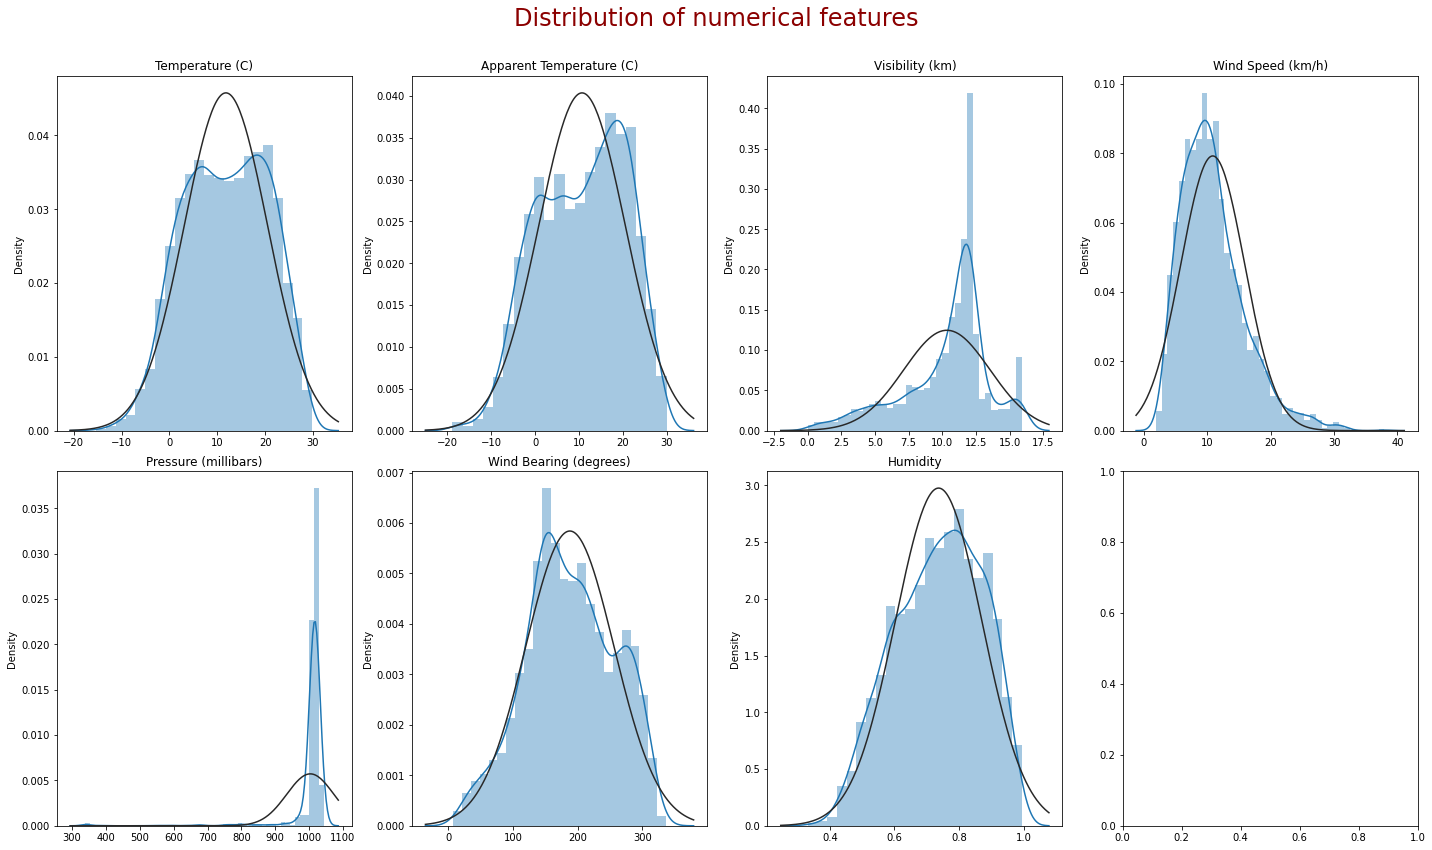

In [28]:
WeatherData.visualize('dist')

# Pre-Processing

## Data Pre-processing 
1- Handling Null Values

2- Dropping Features which have more than 80% of values with the same value

3- removing highly correlated features to avoid multi-collinearity as much as we can

4- removing/clamping outliers

5- transforming highly skewed data to reduce their skewness

6- checking for each features whether it follows a normal distribution or not to decide whether to standardize or min-max scale)

7- classify your categorical features into (ordinal and nominal) to decide which features will be label encoded and which features should be OHE

## 1- Handle Nulls

In [29]:
WeatherData.grabNulls()

(Empty DataFrame
 Columns: [index, Null Count]
 Index: [],                       index  Null Count
 0           Temperature (C)           8
 1  Apparent Temperature (C)           8
 2                  Humidity           8
 3         Wind Speed (km/h)           8
 4    Wind Bearing (degrees)           8
 5           Visibility (km)           8
 6      Pressure (millibars)           8, Empty DataFrame
 Columns: [index, Null Count]
 Index: [])

In [30]:
WeatherData.handleNulls()

In [31]:
WeatherData.grabNulls()

(Empty DataFrame
 Columns: [index, Null Count]
 Index: [], Empty DataFrame
 Columns: [index, Null Count]
 Index: [], Empty DataFrame
 Columns: [index, Null Count]
 Index: [])

## 2- Handle redundant value in cols

In [32]:
WeatherData.handleDuplicates()

[]

## 3- Handle Multicolinearity

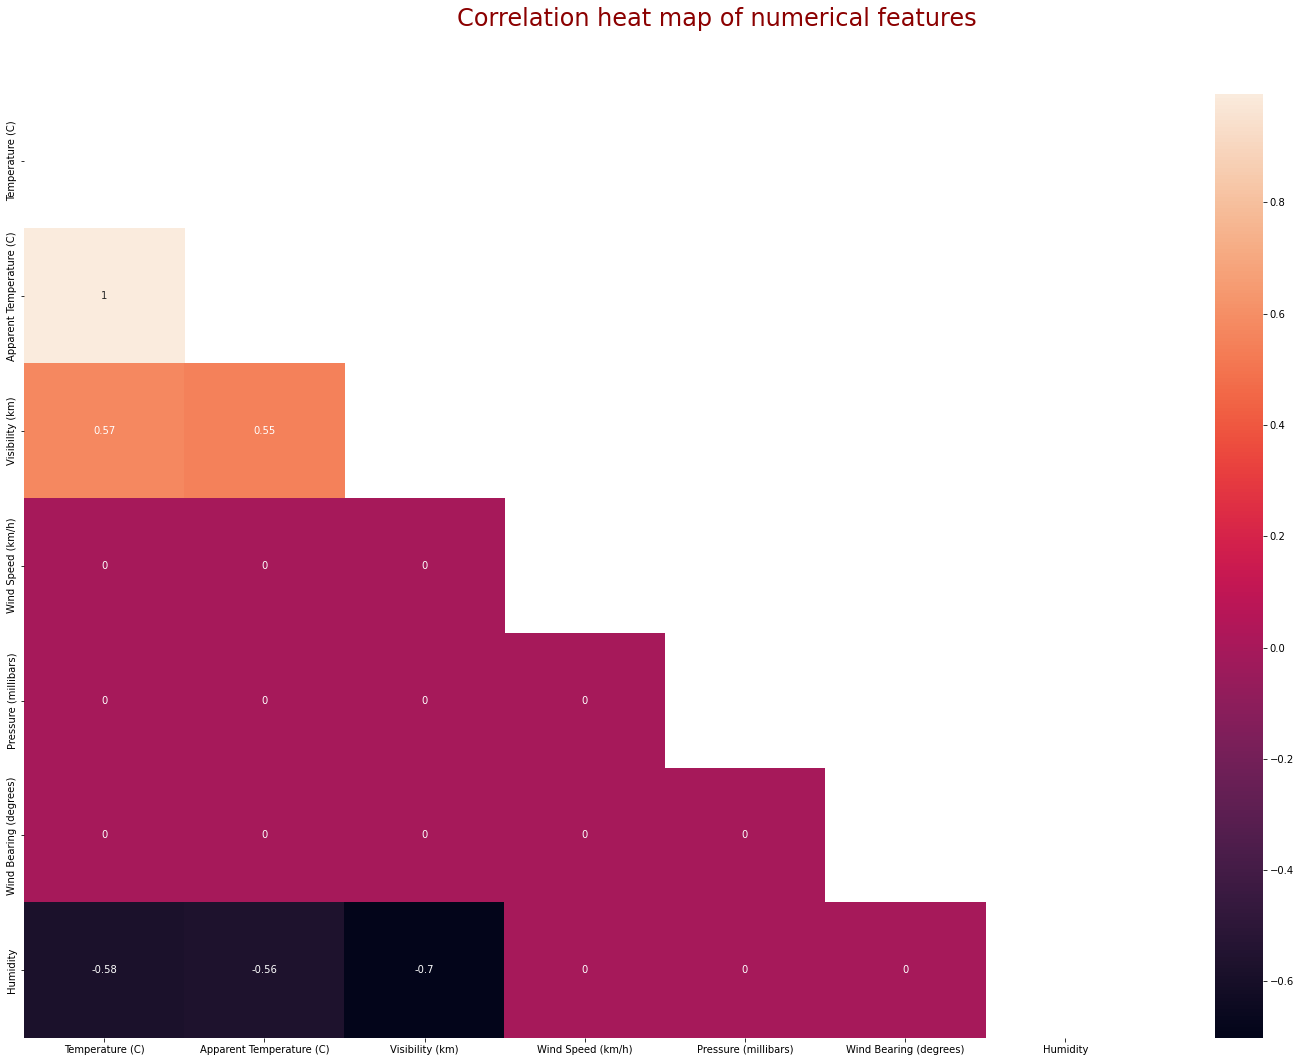

In [33]:
WeatherData.visualize('corr')

> ### Temperature and Apparent Temperature have very hight correlation value, will test removing temperature later

In [34]:
WeatherData.handleCorrFeature(.65)

(['Visibility (km)'],
 [{'Feature Humidity vs Apparent Temperature (C)': -0.5623514976450614,
   'Feature Visibility (km) vs Apparent Temperature (C)': 0.5514533399550016,
   'Feature correlation': -0.7014660798438836}])

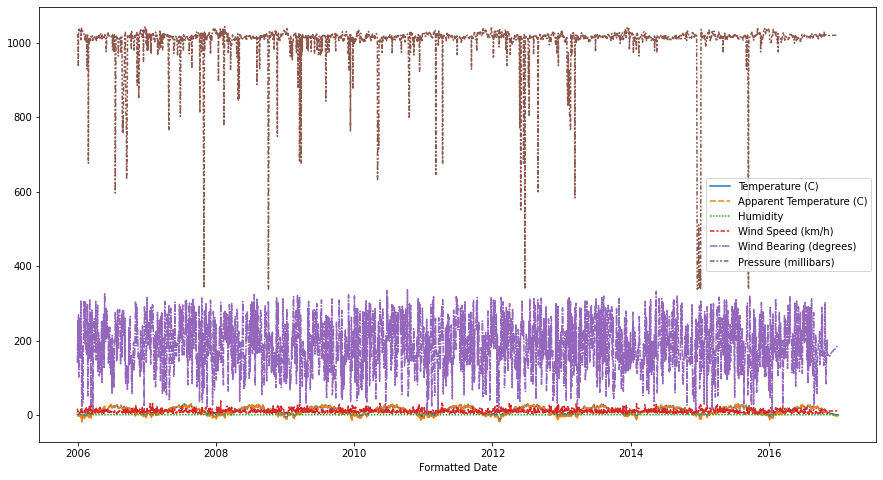

In [35]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()
sns.lineplot(data=WeatherData.train_data, ax=ax);

In [36]:
# WeatherData.train_data['Pressure (millibars)'] = WeatherData.train_data['Pressure (millibars)'] / 1013.25

## 4- Handle outliers

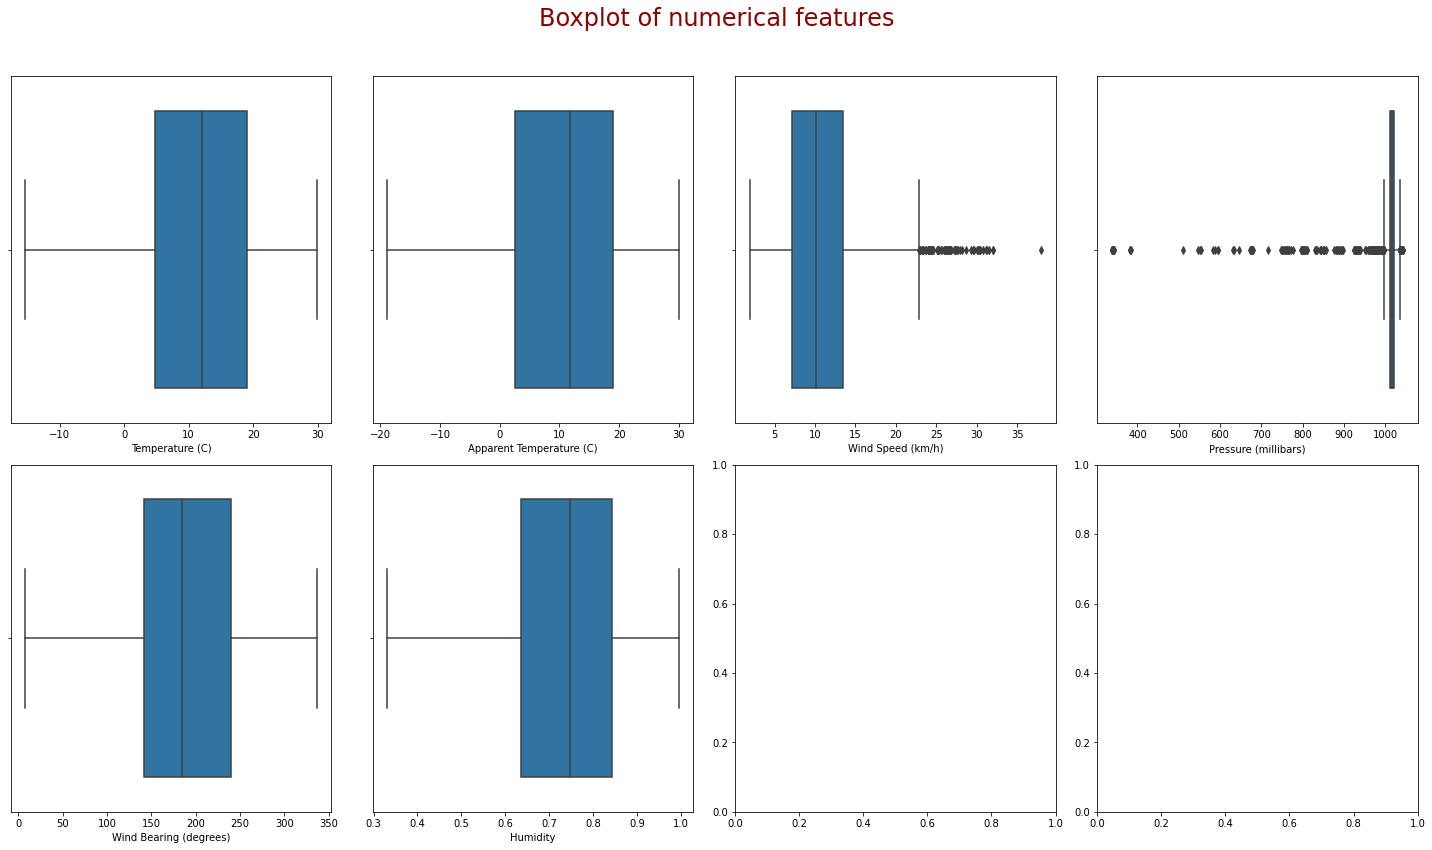

In [37]:
WeatherData.visualize('boxplot')

In [38]:
outliers = WeatherData.checkOutliers(threshold=3)

In [39]:
WeatherData.train_data[['Pressure (millibars)', 'Wind Speed (km/h)']].describe()

,Pressure (millibars),Wind Speed (km/h)
count,2564.000000,2564.000000
mean,1003.573048,10.863381
std,69.709395,5.033673
min,337.626667,1.913217
25%,1010.954167,7.200054
50%,1016.051667,10.077929
75%,1020.631979,13.468992
max,1042.793750,37.929588


### 4.1- Close look at outliers

#### 4.1.1 - Pressure (millibars)

In [40]:
pressure_outliers_idx = outliers['Pressure (millibars)']['Below Lower']
print("wind_gust_outliers Lower Bound is: ", outliers['Pressure (millibars)']['Lower Bound'])

wind_gust_outliers Lower Bound is:  981.9207291666668


In [41]:
pressure_outliers = WeatherData.train_data[['Pressure (millibars)']].loc[pressure_outliers_idx]

In [42]:
pressure_outliers.describe()

,Pressure (millibars)
count,188.000000
mean,834.862062
std,186.946708
min,337.626667
25%,766.823333
50%,927.886667
75%,970.869375
max,981.374167


> There are a lot of extrem outliers in the pressure column

#### 4.1.2 - Wind Speed (km/h)

In [43]:
wind_outliers_idx = outliers['Wind Speed (km/h)']['Above Upper']
print("wind_gust_outliers Upper Bound is: ", outliers['Wind Speed (km/h)']['Upper Bound'])

wind_gust_outliers Upper Bound is:  32.27580416666666


In [44]:
wind_outliers = WeatherData.train_data[['Wind Speed (km/h)']].loc[wind_outliers_idx]

In [45]:
wind_outliers.describe()

,Wind Speed (km/h)
count,1.000000
mean,37.929588
std,NaN
min,37.929588
25%,37.929588
50%,37.929588
75%,37.929588
max,37.929588


> Not that much of extrem outliers

In [46]:
WeatherData.handleOutliers(3)

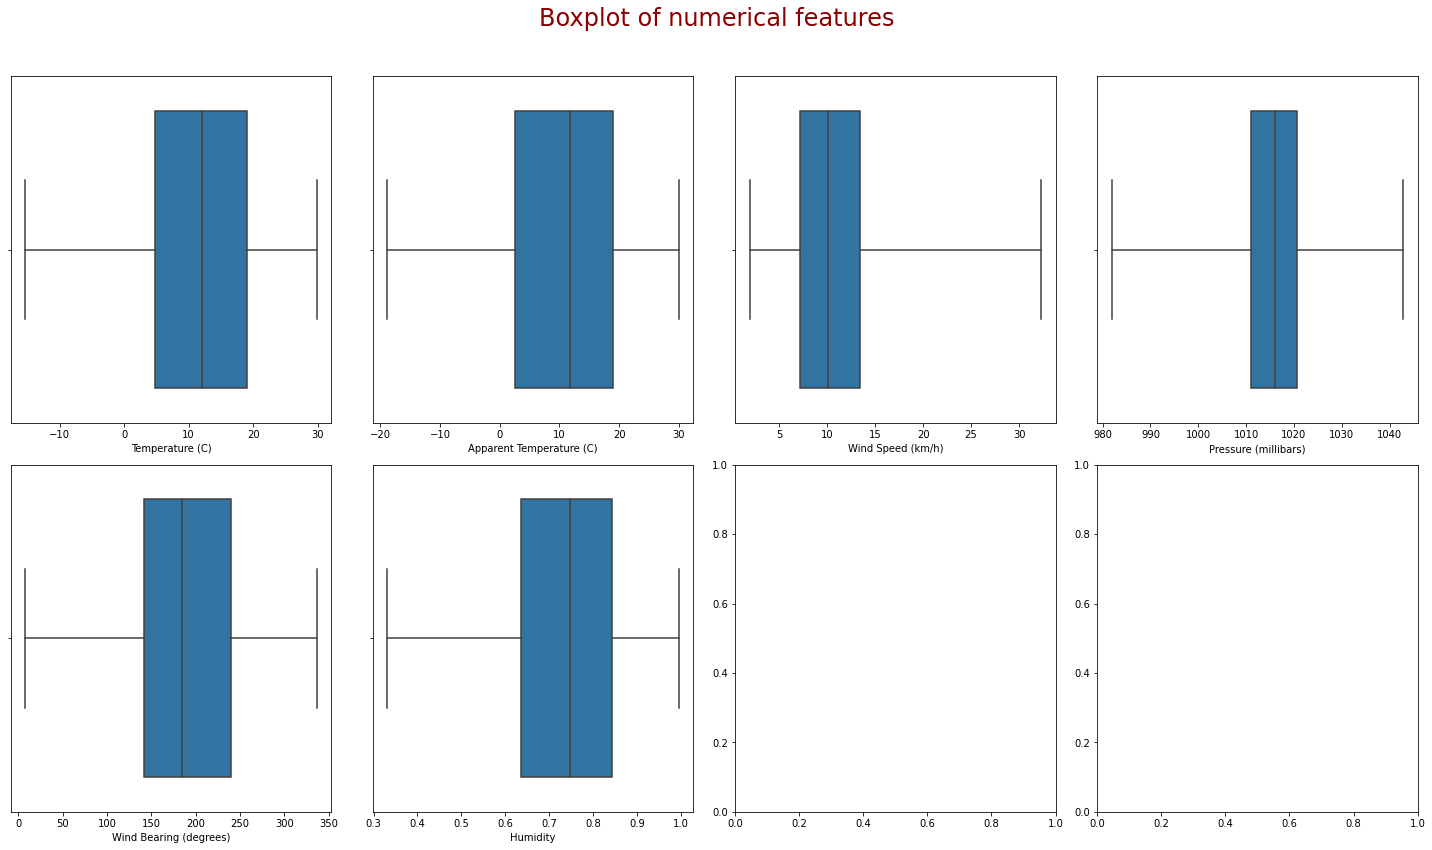

In [47]:
WeatherData.visualize('boxplot', whis=3)

## 5- Handle skewness

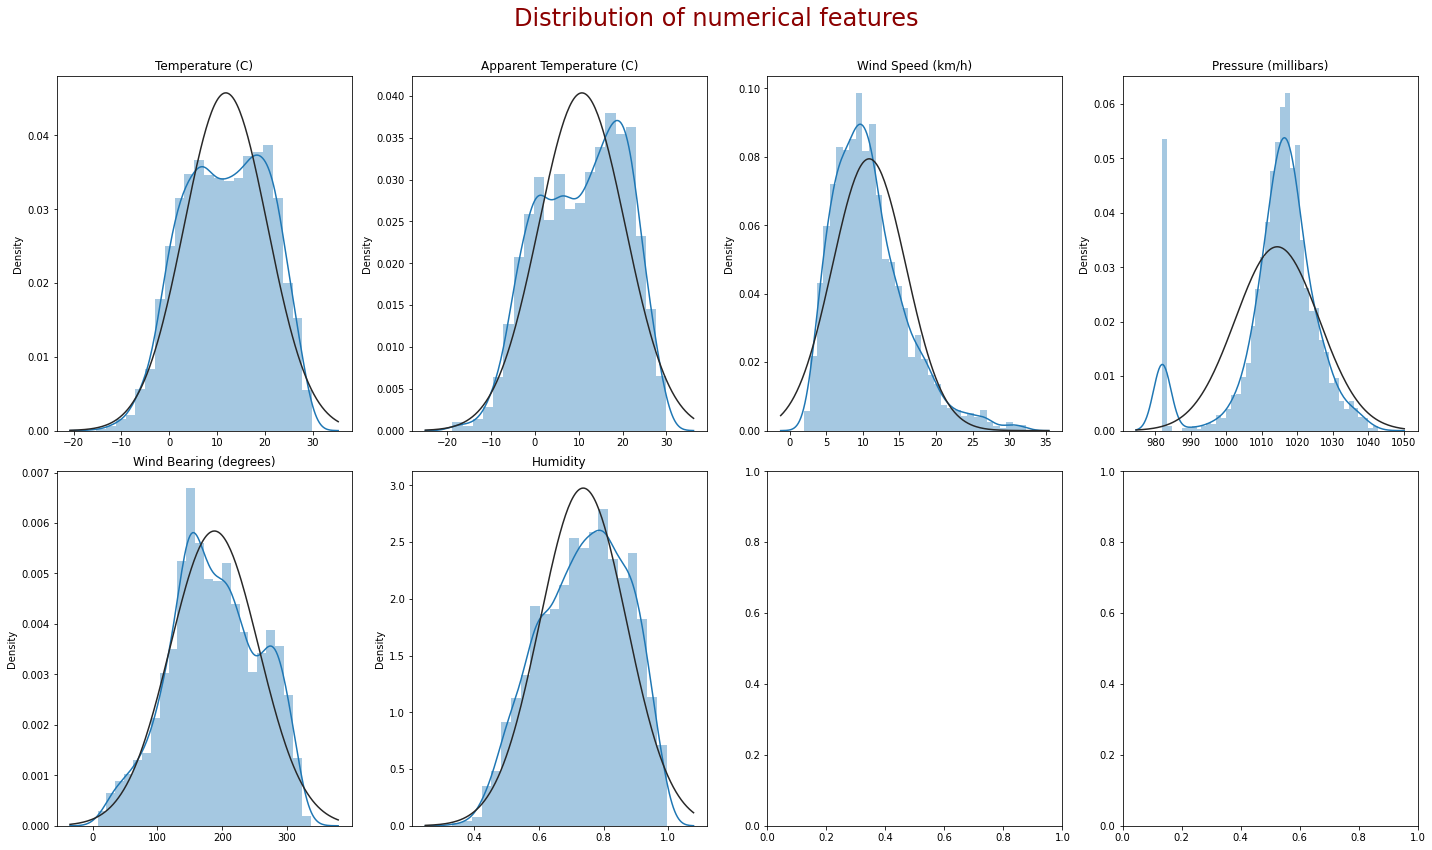

In [48]:
WeatherData.visualize('dist')

In [49]:
WeatherData.calcSkew(target=True)

,Skew Value
Temperature (C),-0.136012
Apparent Temperature (C),-0.236398
Wind Speed (km/h),1.069324
Pressure (millibars),-1.253780
Wind Bearing (degrees),-0.090275
Humidity,-0.245215


> Applying log to Pressure Column increases Skewness so will handle it manually

In [50]:
(np.log(1 + WeatherData.train_data['Pressure (millibars)'])).skew()

-1.297602066133914

In [51]:
WeatherData.handleSkew(target=True, skip=['Pressure (millibars)'])

In [52]:
WeatherData.calcSkew(True)

,Skew Value
Temperature (C),-0.136012
Apparent Temperature (C),-0.236398
Wind Speed (km/h),-0.090439
Pressure (millibars),-1.253780
Wind Bearing (degrees),-0.090275
Humidity,-0.245215


> Handle Pressure skewness

In [53]:
# change scale of values
(WeatherData.train_data['Pressure (millibars)'] / 1013.25).skew()

-1.2547588448692504

In [54]:
(WeatherData.train_data['Pressure (millibars)'] ** (1/2)).skew()

-1.276254803421143

In [55]:
(WeatherData.train_data['Pressure (millibars)'] ** (2)).skew()

-1.21145590613585

In [56]:
(WeatherData.train_data['Pressure (millibars)'] ** (3)).skew()

-1.1677523207669573

In [57]:
from scipy.stats import boxcox

In [58]:
box_cox_test = pd.Series((boxcox(WeatherData.train_data['Pressure (millibars)'])[0]))

In [59]:
box_cox_test.skew()

0.07750733325763809

In [60]:
box_cox_test.describe()

count    2.564000e+03
mean     2.682952e+87
std      7.908076e+86
min      9.759571e+86
25%      2.309802e+87
50%      2.680118e+87
75%      3.061295e+87
max      5.777271e+87
dtype: float64

> Trying multiple approches to handle skewnes non seem to work well only box cox handled the skewness but resulted in very high values in the pressure column so i will leave the skewnes in the pressure column

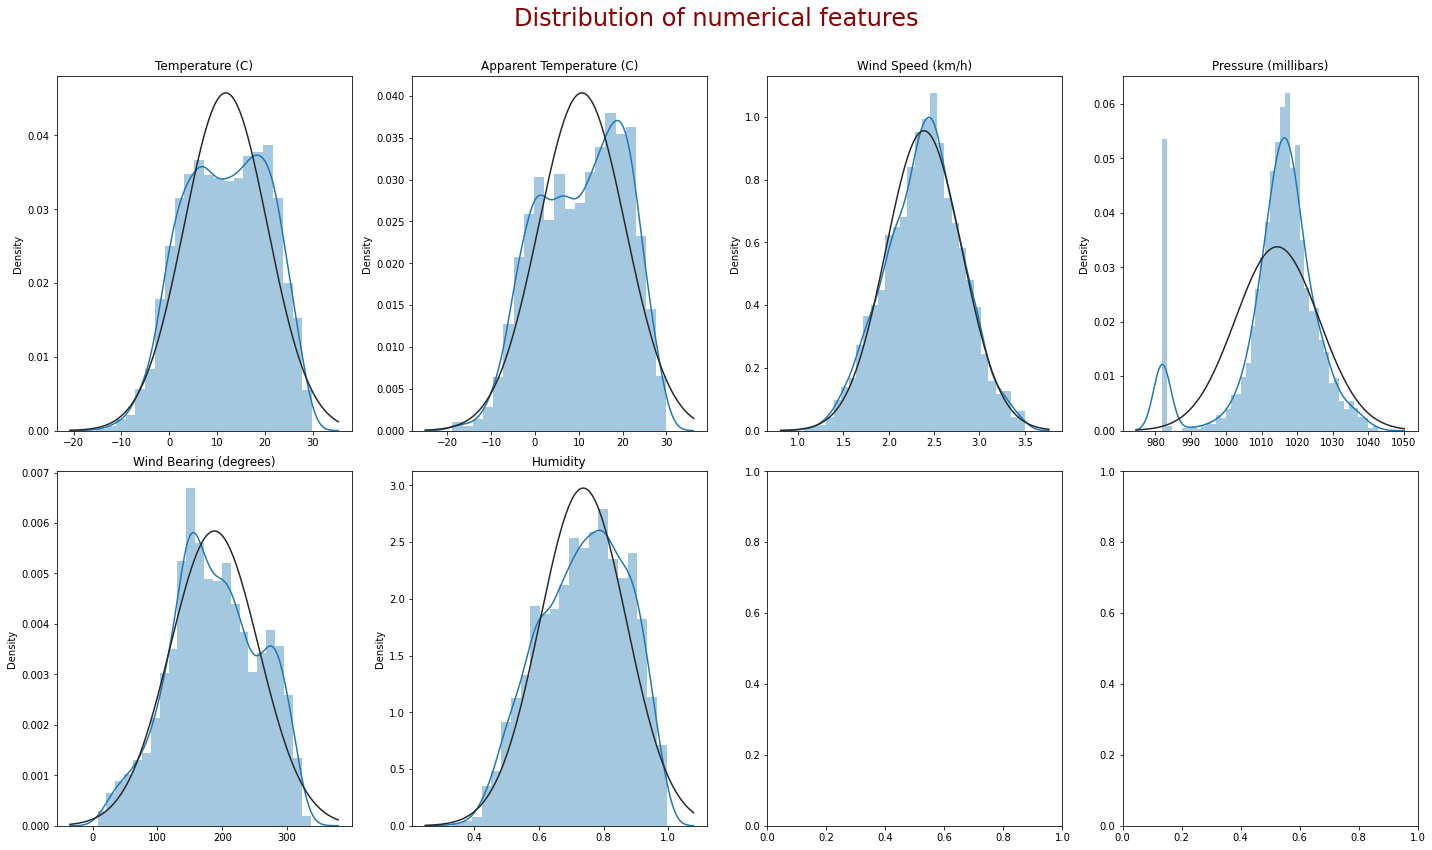

In [61]:
WeatherData.visualize('dist')

## 6- Check distribution

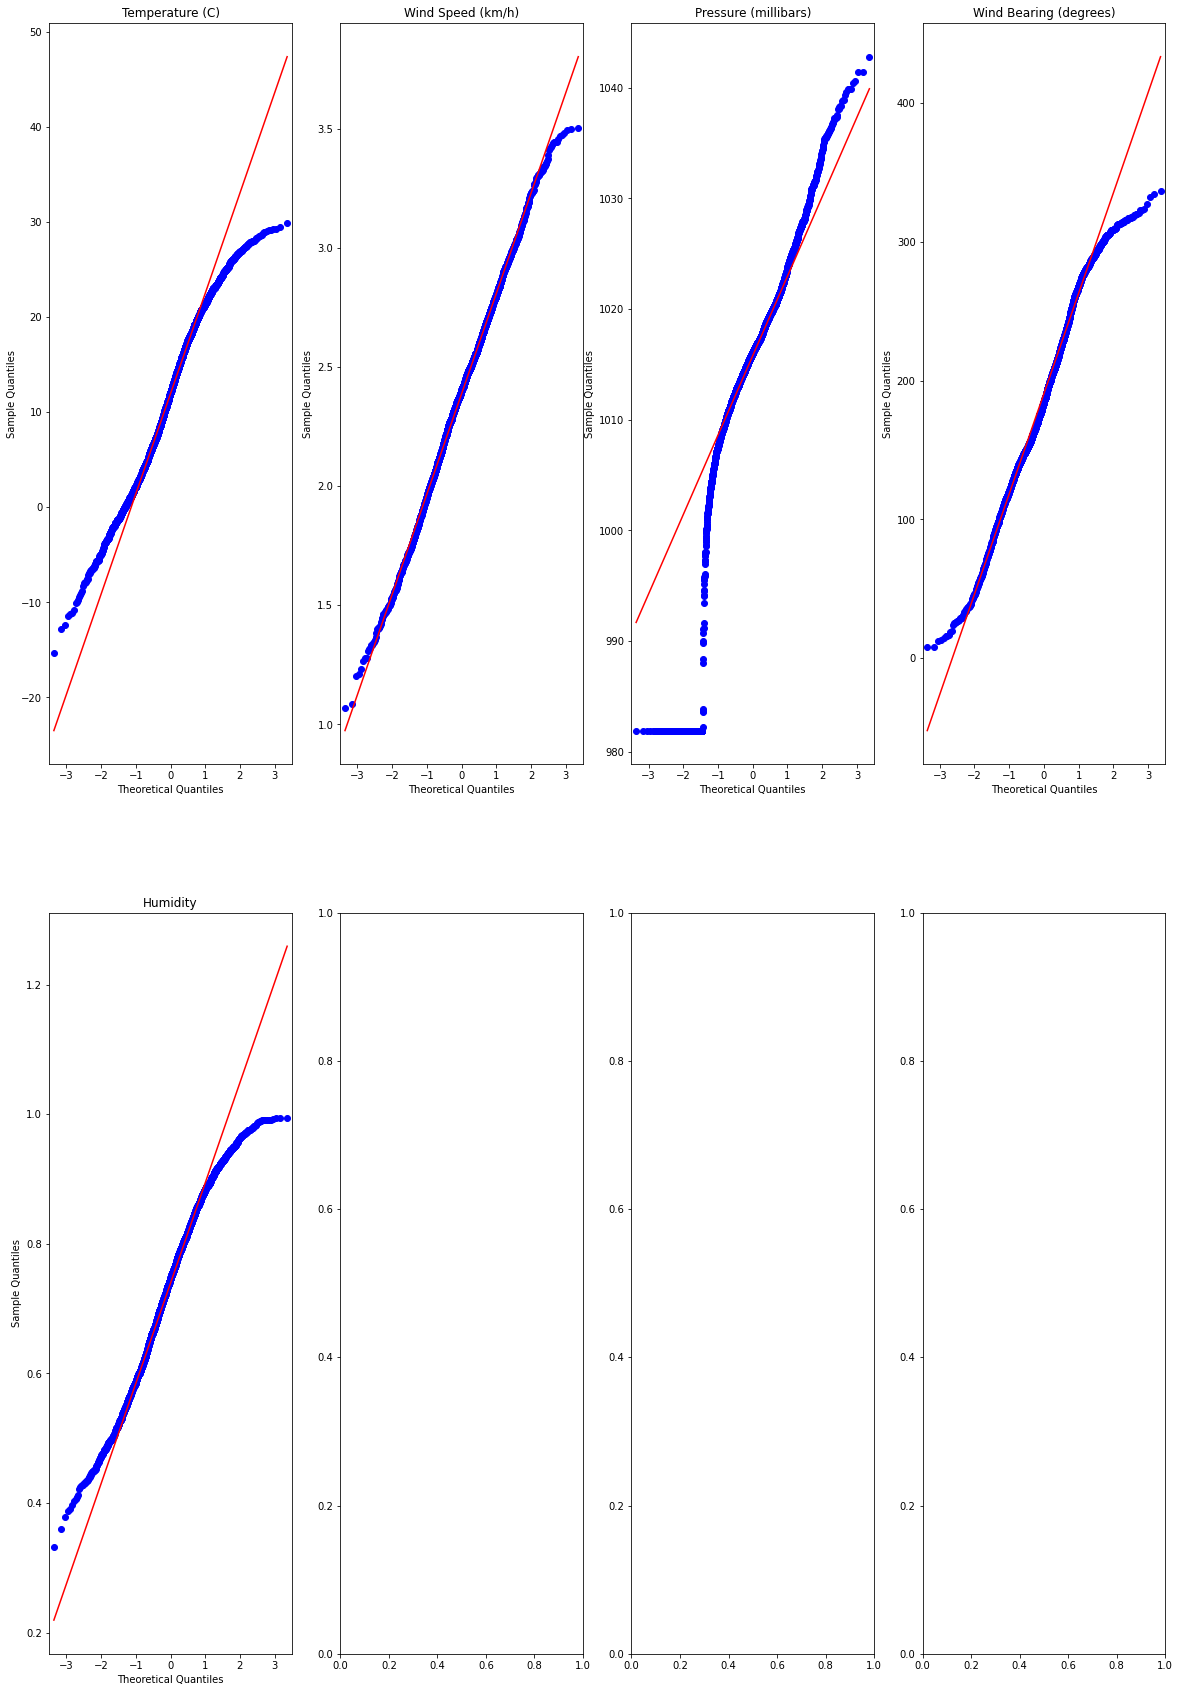

In [62]:
WeatherData.drawQQ()

In [63]:
WeatherData.checkDistribution()

W_Statistic=0.979, p=0.00000112
Temperature (C) does not look Gaussian (reject H0)
W_Statistic=0.976, p=0.00000031
Apparent Temperature (C) does not look Gaussian (reject H0)
W_Statistic=0.997, p=0.62645334
Wind Speed (km/h) looks like gaussian (fail to reject H0)
W_Statistic=0.876, p=0.00000000
Pressure (millibars) does not look Gaussian (reject H0)
W_Statistic=0.985, p=0.00006854
Wind Bearing (degrees) does not look Gaussian (reject H0)
W_Statistic=0.978, p=0.00000077
Humidity does not look Gaussian (reject H0)


(['Wind Speed (km/h)'],
 ['Temperature (C)',
  'Apparent Temperature (C)',
  'Pressure (millibars)',
  'Wind Bearing (degrees)',
  'Humidity'])

In [64]:
WeatherData.featureScale()

W_Statistic=0.982, p=0.00000807
Temperature (C) does not look Gaussian (reject H0)
W_Statistic=0.995, p=0.10843923
Wind Speed (km/h) looks like gaussian (fail to reject H0)
W_Statistic=0.864, p=0.00000000
Pressure (millibars) does not look Gaussian (reject H0)
W_Statistic=0.982, p=0.00000763
Wind Bearing (degrees) does not look Gaussian (reject H0)
W_Statistic=0.978, p=0.00000060
Humidity does not look Gaussian (reject H0)


In [65]:
WeatherData.train_data.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Pressure (millibars)
Formatted Date,,,,,,
2006-05-16 00:00:00+00:00,0.746491,18.383102,0.454146,-0.039678,0.549880,0.614594
2006-10-14 00:00:00+00:00,0.600986,11.528704,0.659548,-1.678177,0.418811,0.785195
2015-02-26 00:00:00+00:00,0.470908,3.691435,0.885678,0.230821,0.764862,0.573148
2014-04-27 00:00:00+00:00,0.696353,16.141898,0.258166,0.609018,0.400051,0.438962
2016-01-13 00:00:00+00:00,0.419355,0.874537,0.803392,0.337020,0.707441,0.473871


## 7- Categorical features

In [66]:
cat = WeatherData.grabCategorical()

In [67]:
cat

[]

## Final data distribution shape

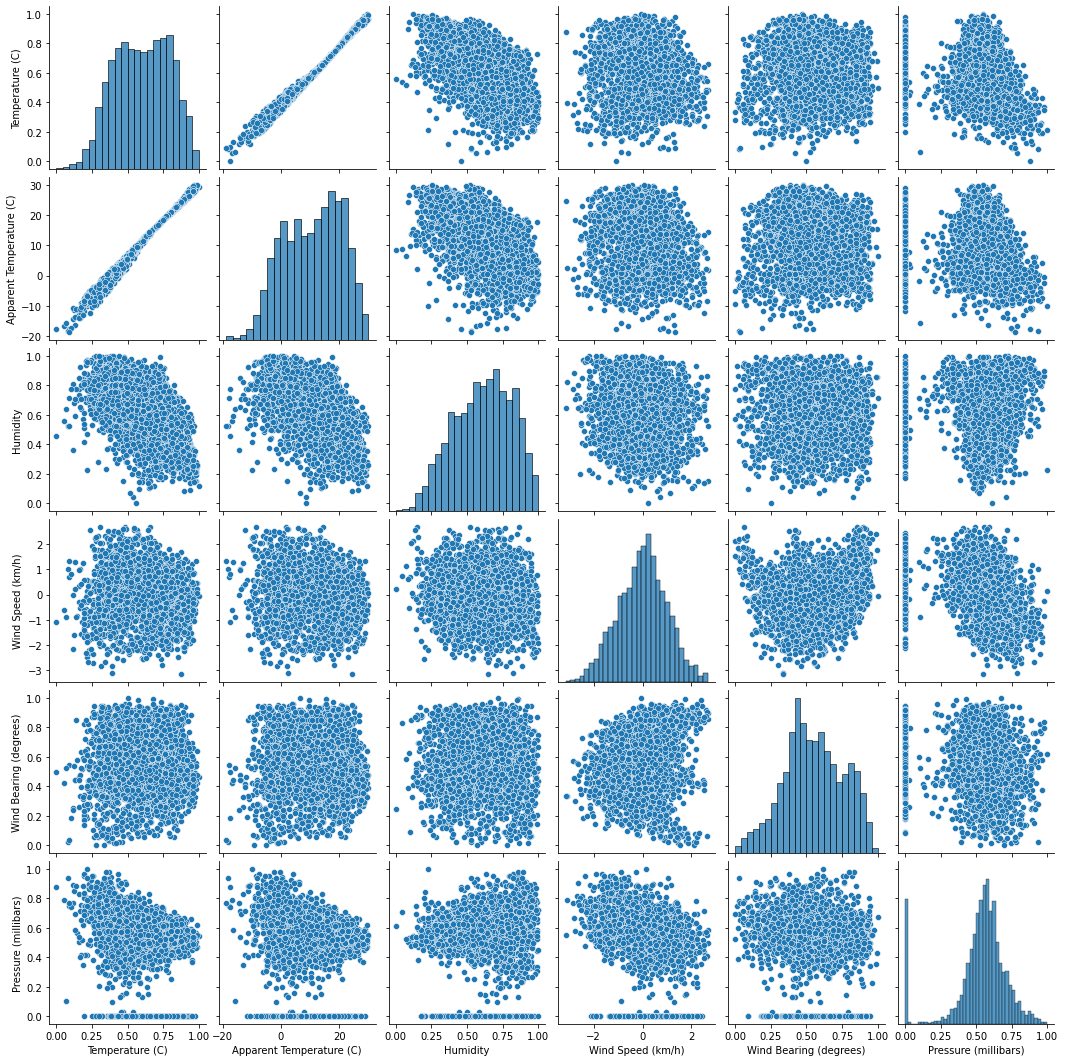

In [68]:
sns.pairplot(WeatherData.train_data)

## Train Data

In [69]:
Train_x = WeatherData.train_data.drop(columns=['Apparent Temperature (C)'])
Train_y = WeatherData.train_data[['Apparent Temperature (C)']]

In [70]:
Train_x.shape, Train_y.shape

((2564, 5), (2564, 1))

## Validation Data

In [71]:
Val_x = WeatherData.val_data.drop(columns=['Apparent Temperature (C)'])
Val_y = WeatherData.val_data[['Apparent Temperature (C)']]

In [72]:
Val_x.shape, Val_y.shape

((642, 5), (642, 1))

## Test Data

In [73]:
Test_x = WeatherData.test_data.drop(columns=['Apparent Temperature (C)'])
Test_y = WeatherData.test_data[['Apparent Temperature (C)']]

In [74]:
Test_x.shape, Test_y.shape

((803, 5), (803, 1))

# Model Testing

### Evaluation Function

> R-squared can be a good measure when model complexity is not very high but since one of the features is highly correlated almost with correlation value of 1 i will be using Adjusted R-squared as a evaluation metric to count for features that is added to the model and not the important in deciding the target value

In [75]:
def EvaluateModel(X, actual, predicted):
    actual = actual.reshape((-1, 1))
    predicted = predicted.reshape((-1, 1))

    # mse
    mse = np.mean(np.square(actual-predicted))

    #rmse
    rmse = np.sqrt(mse)

    #mae
    mae = np.mean(np.abs(actual-predicted))

    #mape
    mape = np.mean((np.abs(actual - predicted) / np.maximum(actual, 1e-5)))

    # r_squared
    rss = np.sum(np.square(actual-predicted))
    tss = np.sum(np.square(actual-np.mean(actual)))
    
    r_squared = 1 - (rss/tss)

    #adjusted r_squared
    adj_r2 = 1 - (((1-r_squared) * (X.shape[0]-1 ))/(X.shape[0] - X.shape[1] -1 ))

    return mse, rmse, mae, mape, r_squared, adj_r2


## 1- Simple Linear Regression

> Temperature and Apparent Temperature have very high correlation values almost 1 so any of them can be used to predict other one so i will be using "Temperature" to predict Apparent Temperature.

### 1.1- Train Data

In [76]:
simple_Train_x = WeatherData.train_data[['Temperature (C)']]
simple_Train_y = WeatherData.train_data[['Apparent Temperature (C)']]

In [77]:
simple_Train_x.shape, simple_Train_y.shape

((2564, 1), (2564, 1))

### 1.2 Validation Data

In [78]:
simple_Val_x = WeatherData.val_data[['Temperature (C)']]
simple_Val_y = WeatherData.val_data[['Apparent Temperature (C)']]

In [79]:
simple_Val_x.shape, simple_Val_y.shape

((642, 1), (642, 1))

### 1.3 Test Data

In [80]:
simple_Test_x = WeatherData.test_data[['Temperature (C)']]
simple_Test_y = WeatherData.test_data[['Apparent Temperature (C)']]

In [81]:
simple_Test_x.shape, simple_Test_y.shape

((803, 1), (803, 1))

### 1.4 Simple LR Model

In [82]:
simple_LR_train_results = pd.DataFrame(columns=['Fit_Intercept', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [83]:
simple_LR_val_results = pd.DataFrame(columns=['Fit_Intercept', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [84]:
simple_LR_test_results = pd.DataFrame(columns=['Fit_Intercept', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [85]:
intercept = [True, False]
for i in intercept:
    simple_LR = LinearRegression(fit_intercept=i)
    simple_LR.fit(simple_Train_x, Train_y)

    # train pred y
    simple_LR_y_train = simple_LR.predict(simple_Train_x)
    # val pred y
    simple_LR_y_val = simple_LR.predict(simple_Val_x)
    # test pred y
    simple_LR_y_test = simple_LR.predict(simple_Test_x)

    # model evaluation on train
    simple_train_scores = EvaluateModel(simple_Train_x.values, Train_y.values, simple_LR_y_train)
    simple_LR_train_results.loc[-1] = [i] + list(simple_train_scores)
    simple_LR_train_results.index = simple_LR_train_results.index + 1  # shifting index
    simple_LR_train_results = simple_LR_train_results.sort_index()

    # model evaluation on validation
    simple_val_scores = EvaluateModel(simple_Val_x.values, Val_y.values, simple_LR_y_val)
    simple_LR_val_results.loc[-1] = [i] + list(simple_val_scores)
    simple_LR_val_results.index = simple_LR_val_results.index + 1  # shifting index
    simple_LR_val_results = simple_LR_val_results.sort_index()

    # model evaluaiton on test
    simple_test_scores = EvaluateModel(simple_Test_x.values, Test_y.values, simple_LR_y_test)
    simple_LR_test_results.loc[-1] = [i] + list(simple_test_scores)
    simple_LR_test_results.index = simple_LR_test_results.index + 1  # shifting index
    simple_LR_test_results = simple_LR_test_results.sort_index()


In [86]:
simple_LR_train_results.sort_values('Adj-R2', ascending=False)

,Fit_Intercept,MSE,RMSE,MAE,MAPE,R2,Adj-R2
1,True,0.836840,0.914789,0.678448,22466.721624,0.991435,0.991432
0,False,37.916198,6.157613,5.049689,187745.643914,0.611941,0.611790


In [87]:
simple_LR_val_results.sort_values('Adj-R2', ascending=False)

,Fit_Intercept,MSE,RMSE,MAE,MAPE,R2,Adj-R2
1,True,0.863650,0.929328,0.692583,20157.945900,0.991078,0.991064
0,False,37.210425,6.100035,4.982259,174530.844328,0.615597,0.614997


In [88]:
simple_LR_test_results.sort_values('Adj-R2', ascending=False)

,Fit_Intercept,MSE,RMSE,MAE,MAPE,R2,Adj-R2
1,True,0.843490,0.918417,0.684693,22648.030651,0.991932,0.991922
0,False,38.709315,6.221681,5.143090,191039.474669,0.629735,0.629273


## 2- Multiple Regression

In [89]:
LR_train_results = pd.DataFrame(columns=['Fit_Intercept', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [90]:
LR_val_results = pd.DataFrame(columns=['Fit_Intercept', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [91]:
LR_test_results = pd.DataFrame(columns=['Fit_Intercept', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [92]:
intercept = [True, False]
for i in intercept:
    LR_intercept = LinearRegression(fit_intercept=i)
    LR_intercept.fit(Train_x, Train_y)

    # train pred y
    LR_intercept_y_train = LR_intercept.predict(Train_x)
    # val pred y
    LR_intercept_y_val = LR_intercept.predict(Val_x)
    # test pred y
    LR_intercept_y_test = LR_intercept.predict(Test_x)

    # model evaluation on train
    train_scores = EvaluateModel(Train_x.values, Train_y.values, LR_intercept_y_train)
    LR_train_results.loc[-1] = [i] + list(train_scores)
    LR_train_results.index = LR_train_results.index + 1  # shifting index
    LR_train_results = LR_train_results.sort_index()

    # model evaluation on validation
    val_scores = EvaluateModel(Val_x.values, Val_y.values, LR_intercept_y_val)
    LR_val_results.loc[-1] = [i] + list(val_scores)
    LR_val_results.index = LR_val_results.index + 1  # shifting index
    LR_val_results = LR_val_results.sort_index()

    # model evaluaiton on test
    test_scores = EvaluateModel(Test_x.values, Test_y.values, LR_intercept_y_test)
    LR_test_results.loc[-1] = [i] + list(test_scores)
    LR_test_results.index = LR_test_results.index + 1  # shifting index
    LR_test_results = LR_test_results.sort_index()


In [93]:
LR_train_results.sort_values('Adj-R2', ascending=False).head(10)

,Fit_Intercept,MSE,RMSE,MAE,MAPE,R2,Adj-R2
1,True,0.565170,0.751778,0.601601,15206.347907,0.994216,0.994204
0,False,6.261277,2.502254,1.955350,42906.921252,0.935918,0.935793


In [94]:
Train_x.shape

(2564, 5)

In [95]:
LR_val_results.sort_values('Adj-R2', ascending=False).head(10)

,Fit_Intercept,MSE,RMSE,MAE,MAPE,R2,Adj-R2
1,True,0.522452,0.722808,0.571334,13062.258459,0.994603,0.994560
0,False,6.914844,2.629609,2.038702,44048.413391,0.928566,0.928005


In [96]:
LR_test_results.sort_values('Adj-R2', ascending=False).head(10)

,Fit_Intercept,MSE,RMSE,MAE,MAPE,R2,Adj-R2
1,True,0.696796,0.834743,0.637341,15750.942251,0.993335,0.993293
0,False,65.109072,8.069019,2.854716,63419.340811,0.377215,0.373308


### 2.1 Test without Temperature Column

In [97]:
train_x_no_temp = WeatherData.train_data.drop(columns=['Temperature (C)', 'Apparent Temperature (C)'])
val_x_no_temp = WeatherData.val_data.drop(columns=['Temperature (C)', 'Apparent Temperature (C)'])
test_x_no_temp = WeatherData.test_data.drop(columns=['Temperature (C)', 'Apparent Temperature (C)'])

In [98]:
LR_no_temp_results = pd.DataFrame(columns=['Data', 'Fit_Intercept', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [99]:
intercept = [True, False]
for i in intercept:
    LR_no_temp = LinearRegression(fit_intercept=i)
    LR_no_temp.fit(train_x_no_temp, Train_y)

    # train pred y
    no_temp_y_train = LR_no_temp.predict(train_x_no_temp)
    # val pred y
    no_temp_y_val = LR_no_temp.predict(val_x_no_temp)
    # test pred y
    no_temp_y_test = LR_no_temp.predict(test_x_no_temp)

    # model evaluation on train
    no_temp_train_scores = EvaluateModel(train_x_no_temp.values, Train_y.values, no_temp_y_train)
    LR_no_temp_results.loc[-1] = ['Train', i] + list(no_temp_train_scores)
    LR_no_temp_results.index = LR_no_temp_results.index + 1  # shifting index
    LR_no_temp_results = LR_no_temp_results.sort_index()

    # model evaluation on validation
    no_temp_val_scores = EvaluateModel(val_x_no_temp.values, Val_y.values, no_temp_y_val)
    LR_no_temp_results.loc[-1] = ['Validation', i] + list(no_temp_val_scores)
    LR_no_temp_results.index = LR_no_temp_results.index + 1  # shifting index
    LR_no_temp_results = LR_no_temp_results.sort_index()

    # model evaluaiton on test
    no_temp_test_scores = EvaluateModel(test_x_no_temp.values, Test_y.values, no_temp_y_test)
    LR_no_temp_results.loc[-1] = ['Test', i] + list(no_temp_test_scores)
    LR_no_temp_results.index = LR_no_temp_results.index + 1  # shifting index
    LR_no_temp_results = LR_no_temp_results.sort_index()


In [100]:
LR_no_temp_results.sort_values(['Data'])

,Data,Fit_Intercept,MSE,RMSE,MAE,MAPE,R2,Adj-R2
0,Test,False,182.712361,13.517114,9.605828,241911.597096,-0.747691,-0.756451
3,Test,True,208.111434,14.426068,7.462635,205205.798117,-0.990640,-1.000618
2,Train,False,97.138902,9.855907,8.126261,209487.679519,0.005818,0.004264
5,Train,True,57.801297,7.602716,6.101995,165021.973281,0.408424,0.407500
1,Validation,False,96.607265,9.828900,8.128649,197854.574359,0.001997,-0.004270
4,Validation,True,60.658947,7.788385,6.225088,167592.435146,0.373362,0.369427


> Removing Temperature from independant features result in very bad results because no linear correlation between independent variables and the target.

## 3- SVR

In [101]:
from sklearn.svm import SVR

In [102]:
svr_train_results = pd.DataFrame(columns=['Kernel', 'C', 'Epsilon', 'degree', 'gamma', 'coef0', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [103]:
svr_val_results = pd.DataFrame(columns=['Kernel', 'C', 'Epsilon', 'degree', 'gamma', 'coef0', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [104]:
svr_test_results = pd.DataFrame(columns=['Kernel', 'C', 'Epsilon', 'degree', 'gamma', 'coef0', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [105]:
C = [.001, .01, .1, 1, 10, 20]
degree = [2, 3, 4, 5, 6]
coef0 = [.001, .01, .1, 1]
gamma = [.001, .01, .1, .2, .3]
epsilon = [.01, .1, .2, .3, .4]
kernel = ['linear', 'poly', 'rbf']

In [106]:
for k in kernel:
    if k == 'linear':
        for c in C:
            for e in epsilon:
                svr = SVR(kernel=k, C=c, epsilon=e)
                svr.fit(Train_x, Train_y)

                # train pred y
                svr_y_train = svr.predict(Train_x)
                # val pred y
                svr_y_val = svr.predict(Val_x)
                # test pred y
                svr_y_test = svr.predict(Test_x)

                # model evaluation on train
                svr_train_scores = EvaluateModel(Train_x.values, Train_y.values, svr_y_train)
                svr_train_results.loc[-1] = [k, c, e, -1, -1, -1] + list(svr_train_scores)
                svr_train_results.index = svr_train_results.index + 1  # shifting index
                svr_train_results = svr_train_results.sort_index()

                # model evaluation on validation
                svr_val_scores = EvaluateModel(Val_x.values, Val_y.values, svr_y_val)
                svr_val_results.loc[-1] = [k, c, e, -1, -1, -1] + list(svr_val_scores)
                svr_val_results.index = svr_val_results.index + 1  # shifting index
                svr_val_results = svr_val_results.sort_index()

                # model evaluaiton on test
                svr_test_scores = EvaluateModel(Test_x.values, Test_y.values, svr_y_test)
                svr_test_results.loc[-1] = [k, c, e, -1, -1, -1] + list(svr_test_scores)
                svr_test_results.index = svr_test_results.index + 1  # shifting index
                svr_test_results = svr_test_results.sort_index()

    elif k == 'poly':
        for c in C:
            for d in degree:
                for g in gamma:
                    for co in coef0:
                        for e in epsilon:
                            svr = SVR(kernel=k, C=c, degree=d, gamma=g, coef0=co, epsilon=e)
                            svr.fit(Train_x, Train_y)

                            # train pred y
                            svr_y_train = svr.predict(Train_x)
                            # val pred y
                            svr_y_val = svr.predict(Val_x)
                            # test pred y
                            svr_y_test = svr.predict(Test_x)

                            # model evaluation on train
                            svr_train_scores = EvaluateModel(Train_x.values, Train_y.values, svr_y_train)
                            svr_train_results.loc[-1] = [k, c, e, d, g, co] + list(svr_train_scores)
                            svr_train_results.index = svr_train_results.index + 1  # shifting index
                            svr_train_results = svr_train_results.sort_index()

                            # model evaluation on validation
                            svr_val_scores = EvaluateModel(Val_x.values, Val_y.values, svr_y_val)
                            svr_val_results.loc[-1] = [k, c, e, d, g, co] + list(svr_val_scores)
                            svr_val_results.index = svr_val_results.index + 1  # shifting index
                            svr_val_results = svr_val_results.sort_index()

                            # model evaluaiton on test
                            svr_test_scores = EvaluateModel(Test_x.values, Test_y.values, svr_y_test)
                            svr_test_results.loc[-1] = [k, c, e, d, g, co] + list(svr_test_scores)
                            svr_test_results.index = svr_test_results.index + 1  # shifting index
                            svr_test_results = svr_test_results.sort_index()

    else:
        for c in C:
            for g in gamma:
                for e in epsilon:
                    svr = SVR(kernel=k, C=c, gamma=g, epsilon=e)
                    svr.fit(Train_x, Train_y)

                    # train pred y
                    svr_y_train = svr.predict(Train_x)
                    # val pred y
                    svr_y_val = svr.predict(Val_x)
                    # test pred y
                    svr_y_test = svr.predict(Test_x)

                    # model evaluation on train
                    svr_train_scores = EvaluateModel(Train_x.values, Train_y.values, svr_y_train)
                    svr_train_results.loc[-1] = [k, c, e, -1, g, -1] + list(svr_train_scores)
                    svr_train_results.index = svr_train_results.index + 1  # shifting index
                    svr_train_results = svr_train_results.sort_index()

                    # model evaluation on validation
                    svr_val_scores = EvaluateModel(Val_x.values, Val_y.values, svr_y_val)
                    svr_val_results.loc[-1] = [k, c, e, -1, g, -1] + list(svr_val_scores)
                    svr_val_results.index = svr_val_results.index + 1  # shifting index
                    svr_val_results = svr_val_results.sort_index()

                    # model evaluaiton on test
                    svr_test_scores = EvaluateModel(Test_x.values, Test_y.values, svr_y_test)
                    svr_test_results.loc[-1] = [k, c, e, -1, g, -1] + list(svr_test_scores)
                    svr_test_results.index = svr_test_results.index + 1  # shifting index
                    svr_test_results = svr_test_results.sort_index()



In [107]:
svr_train_results.sort_values('Adj-R2', ascending=False).head(10)

,Kernel,C,Epsilon,degree,gamma,coef0,MSE,RMSE,MAE,MAPE,R2,Adj-R2
152,poly,20.0,0.20,6,0.3,1,0.064676,0.254315,0.186634,2822.267844,0.999338,0.999337
153,poly,20.0,0.10,6,0.3,1,0.066712,0.258288,0.176002,2683.865993,0.999317,0.999316
151,poly,20.0,0.30,6,0.3,1,0.068152,0.261060,0.203928,3110.383286,0.999302,0.999301
154,poly,20.0,0.01,6,0.3,1,0.069023,0.262722,0.171014,2563.617526,0.999294,0.999292
652,poly,10.0,0.20,6,0.3,1,0.069123,0.262912,0.192705,3084.720075,0.999293,0.999291
653,poly,10.0,0.10,6,0.3,1,0.071350,0.267115,0.183063,2912.394127,0.999270,0.999268
651,poly,10.0,0.30,6,0.3,1,0.072316,0.268916,0.208377,3290.317043,0.999260,0.999258
252,poly,20.0,0.20,5,0.3,1,0.072379,0.269033,0.196653,3064.238478,0.999259,0.999258
172,poly,20.0,0.20,6,0.2,1,0.072555,0.269360,0.197795,3185.924977,0.999257,0.999256
654,poly,10.0,0.01,6,0.3,1,0.073194,0.270544,0.177913,2741.008508,0.999251,0.999249


In [108]:
svr_val_results.sort_values('Adj-R2', ascending=False).head(10)

,Kernel,C,Epsilon,degree,gamma,coef0,MSE,RMSE,MAE,MAPE,R2,Adj-R2
153,poly,20.0,0.10,6,0.3,1,0.070900,0.266270,0.192766,2996.448850,0.999268,0.999262
154,poly,20.0,0.01,6,0.3,1,0.071332,0.267081,0.192243,3044.495003,0.999263,0.999257
653,poly,10.0,0.10,6,0.3,1,0.074671,0.273259,0.197920,3082.814725,0.999229,0.999223
654,poly,10.0,0.01,6,0.3,1,0.075046,0.273945,0.197203,2998.967549,0.999225,0.999219
252,poly,20.0,0.20,5,0.3,1,0.075876,0.275456,0.208289,3094.340601,0.999216,0.999210
652,poly,10.0,0.20,6,0.3,1,0.076571,0.276714,0.205226,3190.364393,0.999209,0.999203
253,poly,20.0,0.10,5,0.3,1,0.078394,0.279989,0.202738,3107.065147,0.999190,0.999184
152,poly,20.0,0.20,6,0.3,1,0.078923,0.280932,0.201460,3020.557416,0.999185,0.999178
174,poly,20.0,0.01,6,0.2,1,0.080124,0.283062,0.204207,3195.367299,0.999172,0.999166
752,poly,10.0,0.20,5,0.3,1,0.080400,0.283550,0.212137,3348.280512,0.999169,0.999163


In [109]:
svr_test_results.sort_values('Adj-R2', ascending=False).head(10)

,Kernel,C,Epsilon,degree,gamma,coef0,MSE,RMSE,MAE,MAPE,R2,Adj-R2
574,poly,20.0,0.01,2,0.2,1,0.228424,0.477937,0.298826,5496.101914,0.997815,0.997801
551,poly,20.0,0.30,2,0.3,1,0.257319,0.507266,0.309550,5145.687558,0.997539,0.997523
553,poly,20.0,0.10,2,0.3,1,0.257760,0.507701,0.292639,5790.883645,0.997534,0.997519
391,poly,20.0,0.30,4,0.1,1,0.276788,0.526106,0.274701,5625.021041,0.997352,0.997336
890,poly,10.0,0.40,4,0.1,1,0.282633,0.531632,0.328580,5643.845214,0.997297,0.997280
594,poly,20.0,0.01,2,0.1,1,0.308731,0.555636,0.319282,5575.818385,0.997047,0.997028
592,poly,20.0,0.20,2,0.1,1,0.321972,0.567426,0.332532,5480.669981,0.996920,0.996901
491,poly,20.0,0.30,3,0.1,1,0.392135,0.626207,0.314421,5757.946632,0.996249,0.996226
1093,poly,10.0,0.10,2,0.1,1,0.408285,0.638972,0.359827,6204.878834,0.996095,0.996070
591,poly,20.0,0.30,2,0.1,1,0.454876,0.674445,0.357484,5616.970444,0.995649,0.995622


## 4- Polynomial Regression

In [110]:
from sklearn.preprocessing import PolynomialFeatures

In [111]:
poly_train_results = pd.DataFrame(columns=['Bias', 'degree', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [112]:
poly_val_results = pd.DataFrame(columns=['Bias', 'degree', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [113]:
poly_test_results = pd.DataFrame(columns=['Bias', 'degree', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [114]:
degrees = [2, 3, 4, 5, 6, 7, 8, 10, 12, 16]
intercept = [True, False]

In [115]:
for d in degrees:     
    for i in intercept:
        Poly_Features = PolynomialFeatures(d, include_bias=i)
        # poly new train
        poly_Train_x = Poly_Features.fit_transform(Train_x)

        # poly new val
        poly_Val_x = Poly_Features.transform(Val_x)

        # poly new test
        poly_Test_x = Poly_Features.transform(Test_x)

        # poly model
        PR = LinearRegression()
        PR.fit(poly_Train_x, Train_y)

        # train pred y
        poly_y_train = PR.predict(poly_Train_x)
        # val pred y
        poly_y_val = PR.predict(poly_Val_x)
        # test pred y
        poly_y_test = PR.predict(poly_Test_x)

        # model evaluation on train
        poly_train_scores = EvaluateModel(poly_Train_x, Train_y.values, poly_y_train)
        poly_train_results.loc[-1] = [i, d] + list(poly_train_scores)
        poly_train_results.index = poly_train_results.index + 1  # shifting index
        poly_train_results = poly_train_results.sort_index()

        # model evaluation on validation
        poly_val_scores = EvaluateModel(poly_Val_x, Val_y.values, poly_y_val)
        poly_val_results.loc[-1] = [i, d] + list(poly_val_scores)
        poly_val_results.index = poly_val_results.index + 1  # shifting index
        poly_val_results = poly_val_results.sort_index()

        # model evaluaiton on test
        poly_test_scores = EvaluateModel(poly_Test_x, Test_y.values, poly_y_test)
        poly_test_results.loc[-1] = [i, d] + list(poly_test_scores)
        poly_test_results.index = poly_test_results.index + 1  # shifting index
        poly_test_results = poly_test_results.sort_index()


In [116]:
poly_train_results.sort_values('Adj-R2', ascending=False).head(10)

,Bias,degree,MSE,RMSE,MAE,MAPE,R2,Adj-R2
4,False,10,0.000010,0.003187,0.001965,23.587850,1.000000,1.000001
5,True,10,0.000010,0.003177,0.001942,21.524109,1.000000,1.000001
2,False,12,0.000001,0.001055,0.000519,4.958622,1.000000,1.000000
3,True,12,0.000001,0.001054,0.000519,4.994602,1.000000,1.000000
1,True,16,0.000003,0.001616,0.000587,4.509541,1.000000,1.000000
0,False,16,0.000002,0.001469,0.000581,4.565078,1.000000,1.000000
6,False,8,0.011764,0.108461,0.070540,1006.024876,0.999880,0.999758
7,True,8,0.011764,0.108461,0.070540,1006.024975,0.999880,0.999758
8,False,7,0.019017,0.137904,0.096322,1653.862672,0.999805,0.999718
9,True,7,0.019017,0.137904,0.096322,1653.862677,0.999805,0.999718


In [117]:
poly_val_results.sort_values('Adj-R2', ascending=False).head(10)

,Bias,degree,MSE,RMSE,MAE,MAPE,R2,Adj-R2
1,True,16,2.942314e+13,5.424310e+06,220714.017486,7.769859e+07,-3.039562e+11,9.886134e+09
0,False,16,5.825783e+11,7.632682e+05,54932.104066,1.726906e+08,-6.018334e+09,1.957554e+08
3,True,12,7.512758e+10,2.740941e+05,22798.026369,8.317340e+07,-7.761066e+08,8.968529e+07
2,False,12,7.418057e+10,2.723611e+05,22678.459683,8.321193e+07,-7.663235e+08,8.857075e+07
4,False,10,7.540511e+07,8.683612e+03,949.172463,1.653981e+07,-7.789727e+05,2.114886e+05
5,True,10,5.688697e+07,7.542345e+03,881.510483,1.602115e+07,-5.876707e+05,1.594835e+05
6,False,8,3.827286e+01,6.186506e+00,1.237358,4.605327e+04,6.046217e-01,1.392926e+00
7,True,8,3.827286e+01,6.186506e+00,1.237358,4.605327e+04,6.046217e-01,1.392318e+00
8,False,7,7.326742e-01,8.559639e-01,0.270681,5.855730e+03,9.924311e-01,1.032344e+00
9,True,7,7.326742e-01,8.559639e-01,0.270681,5.855730e+03,9.924311e-01,1.032130e+00


In [118]:
poly_test_results.sort_values('Adj-R2', ascending=False).head(10)

,Bias,degree,MSE,RMSE,MAE,MAPE,R2,Adj-R2
0,False,16,1.643247e+39,4.053699e+19,3.251934e+18,8.406034e+22,-1.571809e+37,6.449352e+35
1,True,16,8.944297e+36,2.990702e+18,2.081311e+17,4.101651e+21,-8.555451e+34,3.510243e+33
2,False,12,8.168093e+32,2.857988e+16,2.377230e+15,7.016086e+19,-7.812992e+30,1.163606e+30
3,True,12,7.343181e+32,2.709830e+16,2.250352e+15,6.637998e+19,-7.023943e+30,1.045897e+30
5,True,10,5.401961e+30,2.324212e+15,1.942143e+14,5.693713e+18,-5.167116e+28,1.882793e+28
4,False,10,5.165990e+30,2.272881e+15,1.897582e+14,5.699671e+18,-4.941403e+28,1.801366e+28
6,False,8,3.054493e+22,1.747711e+11,1.492594e+10,4.773293e+14,-2.921702e+20,4.841332e+20
7,True,8,3.054493e+22,1.747711e+11,1.492594e+10,4.773293e+14,-2.921702e+20,4.831350e+20
18,False,2,2.724314e+00,1.650549e+00,4.381913e-01,9.838999e+03,9.739412e-01,9.732748e-01
19,True,2,2.724314e+00,1.650549e+00,4.381913e-01,9.838999e+03,9.739412e-01,9.732406e-01


# From scratch implementaions

## 1- Gradient Descent

In [119]:
D = np.c_[Train_x, Train_y]

In [120]:
gd = GradientDescent(data=D, alpha=.01)

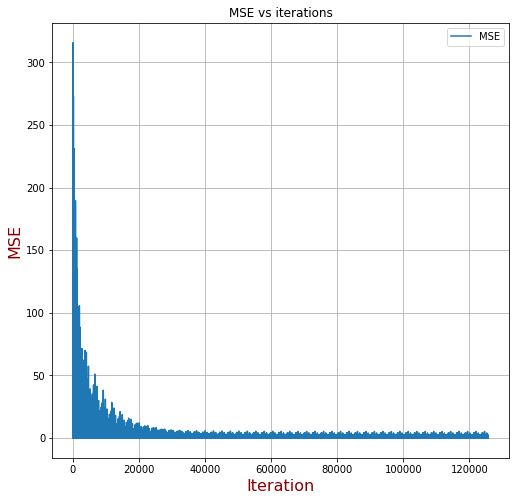

r2_score:  0.994071402664021
Optimizer:  Stochastic
Batch size:  1
Total number of epochs:  49.0
alpha:  0.01


In [121]:
gd.fit(size=1)

In [122]:
Custom_LR_results = pd.DataFrame(columns=['Data', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Adj-R2'])

In [123]:
# theta coeffients
theta = gd.steps[-1]['theta']

In [124]:
ones = np.ones((Train_x.shape[0], 1))
X_train = np.c_[ones, Train_x]
custom_LR_y_Train = X_train @ theta

# Evaluate Train Results
custom_LR_train_scores = EvaluateModel(X_train, Train_y.values, custom_LR_y_Train)

# Add results to the data frame
Custom_LR_results.loc[-1] = ['Train'] + list(custom_LR_train_scores)
Custom_LR_results.index = Custom_LR_results.index + 1  # shifting index
Custom_LR_results = Custom_LR_results.sort_index()

In [125]:
ones = np.ones((Val_x.shape[0], 1))
X_val = np.c_[ones, Val_x]
custom_LR_y_Val = X_val @ theta

# Evaluate Validation Results
custom_LR_val_scores = EvaluateModel(X_val, Val_y.values, custom_LR_y_Val)

# Add results to the data frame
Custom_LR_results.loc[-1] = ['Validation'] + list(custom_LR_val_scores)
Custom_LR_results.index = Custom_LR_results.index + 1  # shifting index
Custom_LR_results = Custom_LR_results.sort_index()

In [126]:
ones = np.ones((Test_x.shape[0], 1))
X_test = np.c_[ones, Test_x]
custom_LR_y_Test = X_test @ theta

# Evaluate Validation Results
custom_LR_test_scores = EvaluateModel(X_test, Test_y.values, custom_LR_y_Test)

# Add results to the data frame
Custom_LR_results.loc[-1] = ['Test'] + list(custom_LR_test_scores)
Custom_LR_results.index = Custom_LR_results.index + 1  # shifting index
Custom_LR_results = Custom_LR_results.sort_index()

In [127]:
Custom_LR_results

,Data,MSE,RMSE,MAE,MAPE,R2,Adj-R2
0,Test,0.732333,0.855765,0.644862,16547.274048,0.992995,0.992942
1,Validation,0.530495,0.728351,0.565320,13485.370422,0.994520,0.994468
2,Train,0.575723,0.758764,0.598858,15872.605026,0.994108,0.994094


# Conclusion

> 1- Due to very high correlation (Linear Correlation) all models lead to good results except high degree polynomial that lead high overfitting on the training data so the test results was not good.

> 2- Removing Temperature from the features result in bad evaluation metrics